In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1 - uniform scalar quantizer

In [279]:
def UniformQuantizer(in_val, n_bits, xmax, m):
    """
    m = 0 => midrise quantizeer
    m = 1 => midtread quantizer
    """
    L = 2**n_bits
    step_size = 2*xmax/L
    q = None
    if m == 0:
        q = np.floor(in_val/step_size)
    elif m == 1:
        q =  np.round(in_val/step_size) 
        
    return q
    

## 2 - uniform scalar dequantizer

In [280]:
def UniformDequantizer(q_ind, n_bits, xmax, m):
    """
    m = 0 => midrise quantizeer
    m = 1 => midtread quantizer
    """
    L = 2**n_bits
    step_size = 2*xmax/L
    if m == 0:
        return q_ind * step_size + step_size/2
    elif m == 1:
        return q_ind * step_size
    

## 3 - Test the quantizer/dequantizer

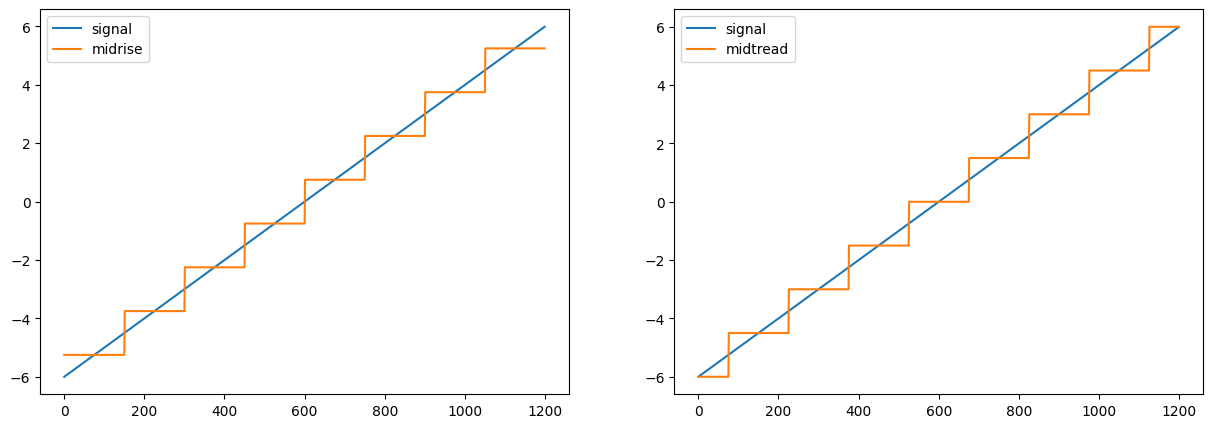

In [281]:
plt.figure(figsize=(15, 5))
y = np.arange(-6, 6, 0.01)
n_bits = 3
xmax = 6



y_quantized_rise = UniformQuantizer(y, n_bits, xmax, 0)
y_dequantized_rise = UniformDequantizer(y_quantized_rise, n_bits, xmax, 0)

plt.subplot(1, 2, 1)
plt.plot(y)
plt.plot(y_dequantized_rise)
plt.legend(["signal", "midrise"])

y_quantized_tread = UniformQuantizer(y, n_bits, xmax, 1)
y_dequantized_tread = UniformDequantizer(y_quantized_tread, n_bits, xmax, 1)

plt.subplot(1, 2, 2)
plt.plot(y)
plt.plot(y_dequantized_tread)
plt.legend(["signal", "midtread"])


## 4 - Test input on a random input signal

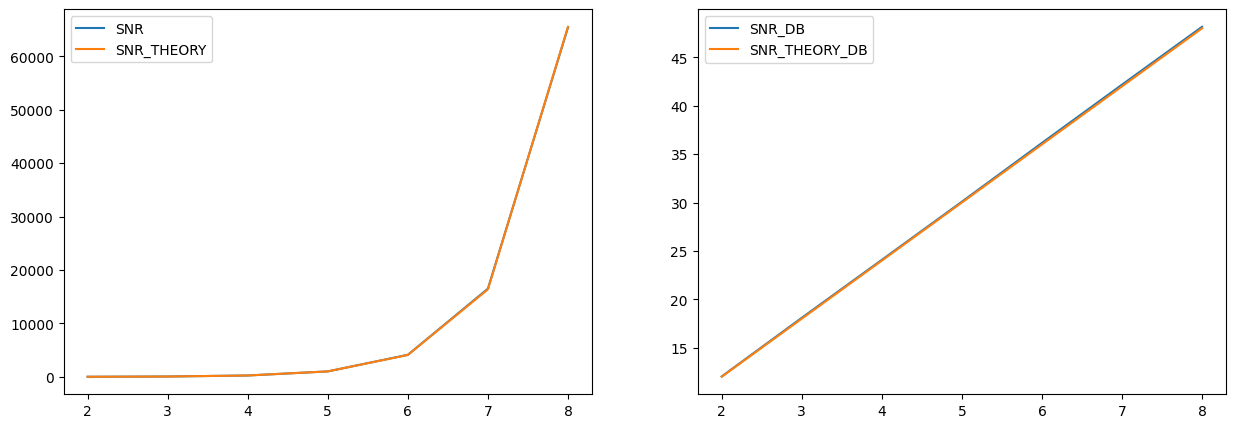

In [282]:

def plot_quantizer_snr(y, xmax, m):
    n_bits_arr = range(2, 8+1)
    SNR = []
    SNR_THEORY = []
    SNR_THEORY_DB = []
    
    for n_bits in n_bits_arr:
        y_quantized = UniformQuantizer(y, n_bits, xmax, m)
        y_dequantized = UniformDequantizer(y_quantized, n_bits, xmax, m)
        quantize_error = np.abs(y - y_dequantized)

        SNR.append( np.mean(y ** 2) / np.mean(quantize_error ** 2) )
        SNR_THEORY.append(2 ** (2*n_bits))
        SNR_THEORY_DB.append(6*n_bits)
        
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(n_bits_arr, SNR)
    plt.plot(n_bits_arr, SNR_THEORY)
    plt.legend(['SNR', 'SNR_THEORY'])

    plt.subplot(1, 2, 2)
    plt.plot(n_bits_arr, 10*np.log10(SNR))
    plt.plot(n_bits_arr, SNR_THEORY_DB)
    plt.legend(['SNR_DB', 'SNR_THEORY_DB'])

y = np.random.uniform(-5, 5, 10000)
plot_quantizer_snr(y, 5, 0)

## 5 - test input on non-uniform random signal

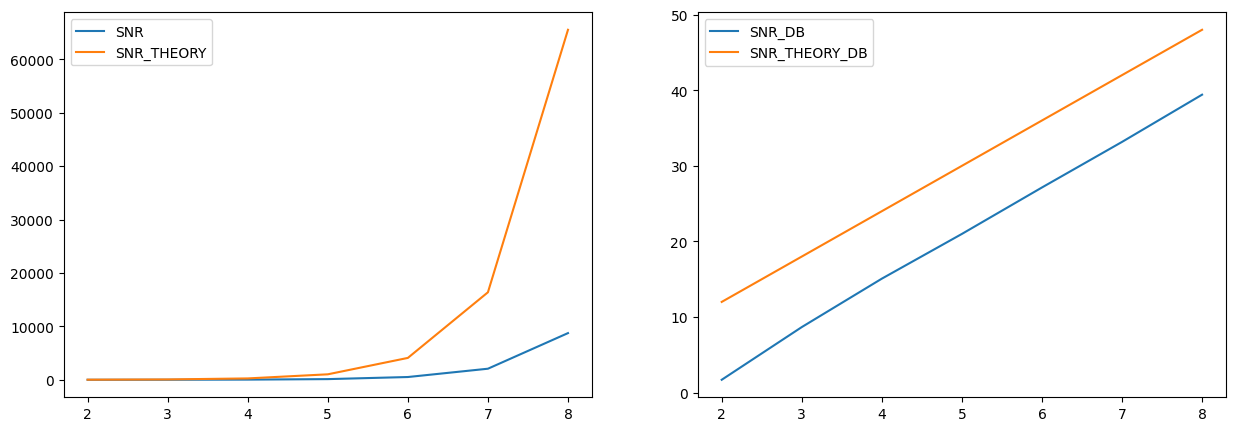

In [283]:
sign = np.random.randint(0, 1, 1000)*2 - 1
amplitude = np.random.exponential(scale=1, size=1000)
y = sign*amplitude
plot_quantizer_snr(y, np.max(np.abs(y)), 0)

In [307]:
def compressor_mue(in_val, mue, ymax, sign):
    y = np.copy(in_val)
    if mue == 0:
        return y
    y /= ymax
    return sign * np.log(1 + mue * np.abs(y)) / np.log(1 + mue)

def expander_mue(in_val, mue, ymax, sign):
    y = np.copy(in_val)
    if mue == 0:
        return y
    return sign * ymax * ((1 + mue) ** np.abs(y) - 1) / mue

Text(0, 0.5, 'SNR')

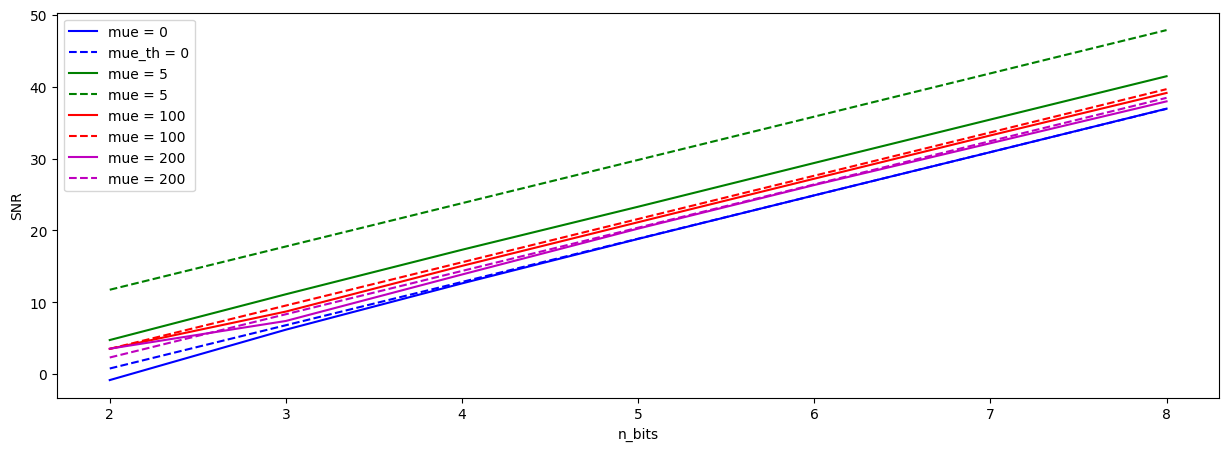

In [309]:
plt.figure(figsize=(15, 5))
sign = np.random.choice([-1, 1], 10000, p=[0.5, 0.5])
amplitude = np.random.exponential(scale=1, size=10000)
y = sign*amplitude

ymax = np.max(np.abs(y))
sign = np.sign(y)

mues = [0.0, 5.0, 100.0, 200.0]
n_bits_arr = range(2, 9)
c = ['b', 'g', 'r', 'm']
legends = ['mue = 0', 'mue_th = 0', 'mue = 5', 'mue = 5', 'mue = 100','mue = 100', 'mue = 200', 'mue = 200']
i = 0
for mue in mues:
    SNR = []
    SNR_THEORY = []
    for n_bits in n_bits_arr:
        y_compresed = compressor_mue(y, mue, ymax, sign)
        y_quantized = UniformQuantizer(y_compresed, n_bits, np.max(np.abs(y_compresed)), 0)
        y_dequantized = UniformDequantizer(y_quantized, n_bits, np.max(np.abs(y_compresed)), 0)
        y_expanded = expander_mue(y_dequantized, mue, ymax, sign)
 
        quantize_error = np.abs(y - y_expanded)

        SNR.append( np.mean(y ** 2) / np.mean(quantize_error ** 2) )

        if mue == 0:
            SNR_THEORY.append(3 * (2**(2*n_bits)) * np.mean(y ** 2) / ymax**2)
        else:
            SNR_THEORY.append(3 * 2**(2*n_bits) / np.log(1 + mue)**2)
            
        #SNR_THEORY_DB.append(6*n_bits)
    plt.plot(n_bits_arr, 10*np.log10(SNR), f'{c[i]}-', n_bits_arr, 10*np.log10(SNR_THEORY), f'{c[i]}--')
    
    i += 1
plt.legend(legends)
plt.xlabel('n_bits')
plt.ylabel('SNR')